In [1]:
import tensorflow as tf
tf.keras.utils.get_file('cats_and_dogs_filtered.zip',"https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip")

'/home/aarav/.keras/datasets/cats_and_dogs_filtered.zip'

In [2]:
import os
import zipfile #to handle zip file

local_zip = '/home/aarav/.keras/datasets/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models

In [4]:
std_normalize = transforms.Normalize(mean=[0, 0, 0],std=[1, 1, 1])

In [5]:
trans_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    std_normalize
])
trans_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    std_normalize
])

In [6]:
train_dataset = torchvision.datasets.ImageFolder('cats_and_dogs_filtered/train',transform=trans_train)

In [7]:
test_dataset = torchvision.datasets.ImageFolder('cats_and_dogs_filtered/validation',transform=trans_test)

In [8]:
batch_size = 20

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [10]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False)

In [11]:
examples = iter(train_loader)
samples ,labels = examples.next()
print(samples.shape)
labels

torch.Size([20, 3, 224, 224])


tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0])

In [12]:
def imshow(img,title):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(25,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(title)
    plt.show()

In [13]:
sample_plot = samples[0:16]
label_plot = labels[0:16]

In [14]:
out = torchvision.utils.make_grid(sample_plot)

In [15]:
class_name = train_dataset.classes

In [16]:
class_name

['cats', 'dogs']

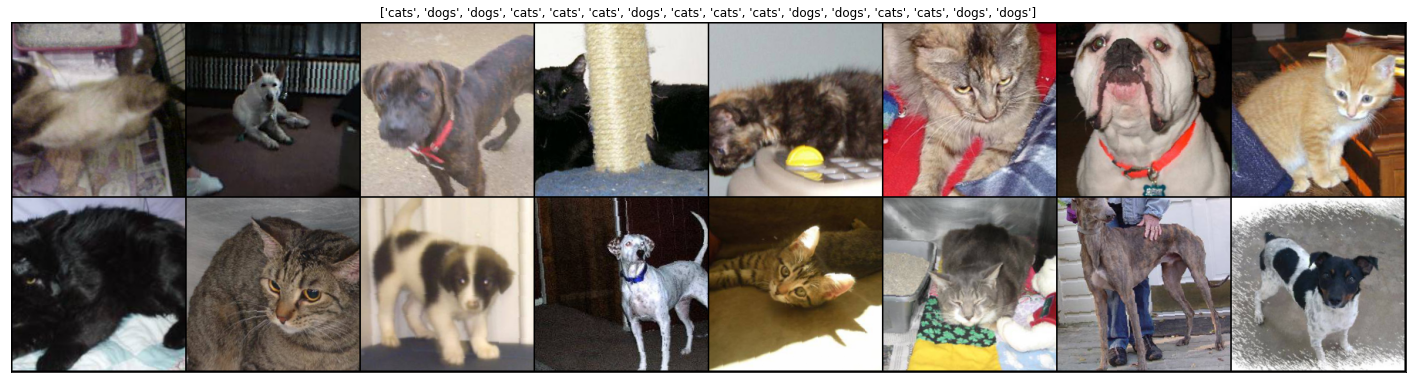

In [17]:
imshow(out,title=[class_name[x] for x in label_plot])

In [18]:
model = models.resnet50(pretrained=True)

In [19]:
#freeze all params
for params in model.parameters():
  params.requires_grad_ = False

In [20]:
#add a new final layer
nr_filters = model.fc.in_features  #number of input features of last layer
model.fc = nn.Sequential(nn.Linear(nr_filters,512),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(512,2))

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
model = model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
#Train the network
num_epochs = 2
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        #labels = labels.unsqueeze(1).float()
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #if (epoch+1) % 1 == 0:    # 
        #    print(f'epoch:{epoch+1},loss={running_loss}')
        #    running_loss = 0.0
        if not i % 8:
            print (f'Epoch: {epoch+1:03d}/{num_epochs:03d} | '
                   f'Batch {i:03d}/{len(train_loader):03d} |' 
                   f' Cost: {running_loss:.2f}')
            running_loss = 0.0

print('Finished Training')

/home/aarav/anaconda3/envs/pract/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 001/002 | Batch 000/100 | Cost: 0.72
Epoch: 001/002 | Batch 008/100 | Cost: 77.18
Epoch: 001/002 | Batch 016/100 | Cost: 9.43
Epoch: 001/002 | Batch 024/100 | Cost: 2.98
Epoch: 001/002 | Batch 032/100 | Cost: 1.50
Epoch: 001/002 | Batch 040/100 | Cost: 1.37
Epoch: 001/002 | Batch 048/100 | Cost: 1.36
Epoch: 001/002 | Batch 056/100 | Cost: 1.16
Epoch: 001/002 | Batch 064/100 | Cost: 1.05
Epoch: 001/002 | Batch 072/100 | Cost: 2.06
Epoch: 001/002 | Batch 080/100 | Cost: 1.73
Epoch: 001/002 | Batch 088/100 | Cost: 1.18
Epoch: 001/002 | Batch 096/100 | Cost: 0.99
Epoch: 002/002 | Batch 000/100 | Cost: 0.21
Epoch: 002/002 | Batch 008/100 | Cost: 0.52
Epoch: 002/002 | Batch 016/100 | Cost: 0.53
Epoch: 002/002 | Batch 024/100 | Cost: 1.21
Epoch: 002/002 | Batch 032/100 | Cost: 1.79
Epoch: 002/002 | Batch 040/100 | Cost: 1.42
Epoch: 002/002 | Batch 048/100 | Cost: 0.85
Epoch: 002/002 | Batch 056/100 | Cost: 1.03
Epoch: 002/002 | Batch 064/100 | Cost: 0.42
Epoch: 002/002 | Batch 072/100 

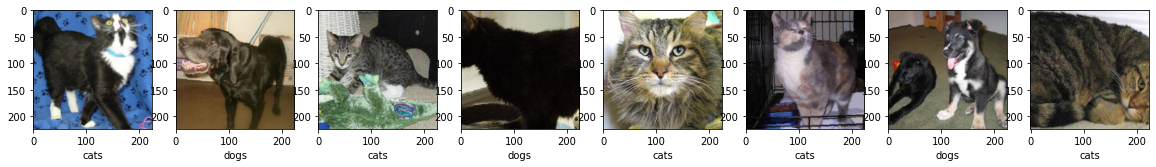

In [24]:
import numpy as np
test_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                         batch_size=batch_size, 
                         shuffle=True)

for features, targets in test_loader:
    break
    

predictions = model(features[:8].to(device))
#print(predictions)
#predictions = int(predictions)
d = test_dataset.classes
#print(d)
#print(predictions)
predictions = torch.max(predictions,dim=1)[1]
predictions = predictions.cpu()
predictions = predictions.numpy()
fig, ax = plt.subplots(1, 8, figsize=(20, 10))
for i in range(8):
    img = features[i]
    ax[i].imshow(np.transpose(img, (1, 2, 0)))
    ax[i].set_xlabel(d[int(np.array(predictions[i].item()).round())])
    #print(int(np.array(predictions[i].item()).round()))

plt.show()